# Case Técnico iFood — Estratégia de Cupons e Retenção (A/B) + Segmentação

Este notebook está organizado para responder diretamente ao case:

* **Escopo e integridade dos dados** (janela, população A/B vs pedidos)
* **Métrica primária: retenção** (D7/D14/D30 com tratamento de censura)
* **Resultados do A/B e diagnósticos**
* **Segmentação (RFM) e heterogeneidade de impacto**
* **Viabilidade financeira e decisão**
* **Recomendações + proposta de novo desenho de teste**


## Resumo High-Level

- **Pergunta:** O cupom aumentou **retenção** (recompra) de forma estatisticamente e economicamente relevante?
- **Métrica primária:** Retenção D7/D14/D30 (apenas usuários elegíveis, devido à janela observada).
- **Métricas secundárias:** Pedidos por usuário, GMV por usuário, AOV (ticket médio), distribuição e cauda.
- **Decisão:** (Go / No-Go / Ajustar targeting) — suportada por efeito, IC e cenários de ROI.

> Nota: a base do teste A/B está praticamente toda observável em pedidos (**apenas 1 usuário do A/B não está em `orders`**), então “conversão (comprar vs não comprar)” é pouco informativa neste dataset.


# 1. Configuração do Ambiente e Bibliotecas

Utilizarei o **Apache Spark** como motor de processamento principal devido à volumetria dos dados (3.6 milhões de pedidos), garantindo escalabilidade. Para visualização e testes estatísticos pontuais, converterei os dados agregados para Pandas/SciPy.

In [1]:
# 1. Instalação das dependências
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# 2. Download e extração dos arquivos do ambiente Spark
import os
spark_tgz_file = "spark-3.5.0-bin-hadoop3.tgz"
spark_dir = "spark-3.5.0-bin-hadoop3"

if not os.path.exists(spark_tgz_file):
    print(f"Baixando {spark_tgz_file}...")
    !wget -q http://archive.apache.org/dist/spark/spark-3.5.0/{spark_tgz_file}
else:
    print(f"{spark_tgz_file} já existe, pulando download.")

if not os.path.exists(spark_dir):
    print(f"Extraindo {spark_tgz_file}...")
    !tar xf {spark_tgz_file}
else:
    print(f"{spark_dir} já existe, pulando download.")

# 3. Configuração das Variáveis de Ambiente
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_dir}"
os.environ["PATH"] += f":/content/{spark_dir}/bin:/content/{spark_dir}/sbin"

# 4. Instalando findspark e pyspark
!pip install -q findspark pyspark

# Explicitando o interpretador Python para o Spark
os.environ['PYSPARK_PYTHON'] = 'python3'
os.environ['PYSPARK_DRIVER_PYTHON'] = 'python3'

# 5. Inicializando findspark e a Sessão Spark e declarando funções e tipagens
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *

# 6. Configuração otimizada para memória local do Colab
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("iFood_Case_Analysis") \
    .config("spark.ui.port", "4050") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Propriedade de visualização para melhorar a exibição em consoles

print(f"""
Ambiente Spark criado!
Nome da aplicação Spark: {spark.sparkContext.appName}
Versão do Spark utilizada: {spark.version}
""")

Baixando spark-3.5.0-bin-hadoop3.tgz...
Extraindo spark-3.5.0-bin-hadoop3.tgz...

Ambiente Spark criado!
Nome da aplicação Spark: iFood_Case_Analysis
Versão do Spark utilizada: 3.5.0



# 2. Engenharia de Dados (ETL)

##2.1 Criação dos ambientes de dados

In [2]:
# 1. Definição da Estrutura de Pastas
BASE_DIR = "/content/ifood_data_case"
DIRS = {
    "RAW": os.path.join(BASE_DIR, "raw_data"),                # Dados originais (Bronze)
    "STAGING": os.path.join(BASE_DIR, "staging"),             # Dados extraídos/temporários
    "CURATED": os.path.join(BASE_DIR, "curated_data"),        # Dados limpos/tabelas fato (Silver)
    "SPECIALIZED": os.path.join(BASE_DIR, "specialized_data") # Agregações para negócio (Gold)
}

# 2. Criando as pastas fisicamente
for key, path in DIRS.items():
    os.makedirs(path, exist_ok=True)
    print(f"Diretório criado: {path}")

Diretório criado: /content/ifood_data_case/raw_data
Diretório criado: /content/ifood_data_case/staging
Diretório criado: /content/ifood_data_case/curated_data
Diretório criado: /content/ifood_data_case/specialized_data


## 2.1 Download dos dados do case

In [3]:
# Lista das URLs públicas dos dados do case
urls = {
    "order.json.gz": "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/order.json.gz",
    "consumer.csv.gz": "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/consumer.csv.gz",
    "restaurant.csv.gz": "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/restaurant.csv.gz",
    "ab_test_ref.tar.gz": "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/ab_test_ref.tar.gz"
}

# Loop de download usando wget direcionando para a pasta correta
for filename, url in urls.items():
    output_path = os.path.join(DIRS["RAW"], filename)
    print(f"Baixando {filename}...")
    os.system(f"wget -q -O {output_path} {url}")

print("Downloads concluídos na pasta 'raw_data'.")

Baixando order.json.gz...
Baixando consumer.csv.gz...
Baixando restaurant.csv.gz...
Baixando ab_test_ref.tar.gz...
Downloads concluídos na pasta 'raw_data'.


##2.2 Descompressão do arquivo do teste A/B

In [4]:
# 1. O arquivo ab_test_ref vem em tar.gz e precisa ser extraído para leitura
print("Extraindo arquivo do Teste AB para 'staging'...")
input_tar = os.path.join(DIRS["RAW"], "ab_test_ref.tar.gz")
output_tar_dir = DIRS["STAGING"]
# 2. Extrai o conteúdo do tar para a pasta staging
os.system(f"tar -xzvf {input_tar} -C {output_tar_dir}")
print("Estrutura de arquivos pronta.")

Extraindo arquivo do Teste AB para 'staging'...
Estrutura de arquivos pronta.


##2.3 Definição de schemas com base no PDF do case e análise dos registros

Nesta etapa, realizamos a ingestão dos dados brutos.

**Decisão de Arquitetura:** Optamos por definir os **Schemas (StructType)** explicitamente ao invés de usar `inferSchema`.
* **Motivo 1:** Performance (leitura mais rápida).
* **Motivo 2:** Qualidade (garante que datas sejam datas e números sejam números, evitando erros de conversão silenciosos).

In [5]:
# 1. Schema Auxiliar para Valores Monetários (Reutilizável)
# Aparece repetidamente em unitPrice, totalValue, addition, discount, etc.
monetary_struct = StructType([
    StructField("value", StringType(), True),     # "2800" (String)
    StructField("currency", StringType(), True)   # "BRL"
])

# 2. Schema para 'garnishItems' (Itens de acompanhamento/adicionais)
# Ex: Arroz branco dentro do prato principal
# O schema foi inferido ao analisar amostras deste campo em registors da base
garnish_item_schema = StructType([
    StructField("name", StringType(), True),
    StructField("addition", monetary_struct, True),
    StructField("discount", monetary_struct, True),
    StructField("quantity", DoubleType(), True),
    StructField("sequence", IntegerType(), True),
    StructField("unitPrice", monetary_struct, True),
    StructField("categoryId", StringType(), True),
    StructField("externalId", StringType(), True),
    StructField("totalValue", monetary_struct, True),
    StructField("categoryName", StringType(), True),
    StructField("integrationId", StringType(), True)
])

# 3. Schema Principal de Itens
# O schema foi inferido ao analisar amostras deste campo em registors da base
item_schema = ArrayType(StructType([
    StructField("name", StringType(), True),
    StructField("addition", monetary_struct, True),
    StructField("discount", monetary_struct, True),
    StructField("quantity", DoubleType(), True),
    StructField("sequence", IntegerType(), True),
    StructField("unitPrice", monetary_struct, True),
    StructField("externalId", StringType(), True),
    StructField("totalValue", monetary_struct, True),
    StructField("customerNote", StringType(), True),
    StructField("garnishItems", ArrayType(garnish_item_schema), True),
    StructField("integrationId", StringType(), True),
    StructField("totalAddition", monetary_struct, True),
    StructField("totalDiscount", monetary_struct, True)
]))

# 4. Schema do Arquivo de Pedidos (orders.json)
# O schema foi declarado com base na descrição do arquivo do case
schema_orders = StructType([
    StructField("order_id", StringType(), True),
    StructField("customer_id", StringType(), True),
    StructField("merchant_id", StringType(), True),
    StructField("order_total_amount", DoubleType(), True),
    StructField("order_created_at", StringType(), True),
    StructField("order_scheduled", BooleanType(), True),
    StructField("items", StringType(), True),
    StructField("delivery_address_city", StringType(), True),
    StructField("delivery_address_state", StringType(), True),
    StructField("delivery_address_zip_code", StringType(), True),
    StructField("delivery_address_latitude", StringType(), True),
    StructField("delivery_address_longitude", StringType(), True),
    StructField("merchant_latitude", StringType(), True),
    StructField("merchant_longitude", StringType(), True)
])

# 5. Schema de Usuários (consumer.csv)
# O schema foi declarado com base na descrição do arquivo do case
schema_consumers = StructType([
    StructField("customer_id", StringType(), True),
    StructField("language", StringType(), True),
    StructField("created_at", StringType(), True),
    StructField("active", BooleanType(), True),
    StructField("customer_name", StringType(), True),
    StructField("customer_phone_area", StringType(), True),
    StructField("customer_phone_number", StringType(), True)
])

# 6. Schema de Restaurantes (restaurant.csv)
# O schema foi declarado com base na descrição do arquivo do case
schema_restaurants = StructType([
    StructField("id", StringType(), True),
    StructField("created_at", StringType(), True),
    StructField("enabled", BooleanType(), True),
    StructField("price_range", IntegerType(), True),
    StructField("average_ticket", DoubleType(), True),
    StructField("delivery_time", DoubleType(), True),
    StructField("merchant_city", StringType(), True),
    StructField("merchant_state", StringType(), True)
])

# 7. Schema Teste A/B (ab_test_ref.csv)
# O schema foi declarado com base na descrição do arquivo do case
schema_ab = StructType([
    StructField("customer_id", StringType(), True),
    StructField("is_target", StringType(), True) # target vs control
])

print("Schemas definidos.")

Schemas definidos.


##2.4 Leitura dos dados do case


O fluxo de dados seguirá a seguinte lógica de otimização:
1.  **Ingestão:** Leitura direta dos arquivos comprimidos (`.gz`).
2.  **Otimização:** Conversão imediata para formato **Parquet** (Colunar e Tipado), acelerando as consultas analíticas subsequentes.

In [6]:
def load_and_prep_data_organized(spark, dirs_dict):
    """
    Lê os dados a partir da estrutura organizada de diretórios.
    """

    # Caminhos completos
    path_orders = os.path.join(dirs_dict["RAW"], "order.json.gz")
    path_consumers = os.path.join(dirs_dict["RAW"], "consumer.csv.gz")
    path_restaurants = os.path.join(dirs_dict["RAW"], "restaurant.csv.gz")

    # Nota: O tar.gz extrai o arquivo geralmente mantendo o nome original.
    # Vamos assumir que ele extraiu 'ab_test_ref.csv' dentro de staging.
    path_ab = os.path.join(dirs_dict["STAGING"], "ab_test_ref.csv")

    # 1. Pedidos (JSON)
    print(f"Lendo Orders de: {path_orders}")
    df_orders = spark.read.schema(schema_orders).json(path_orders)
    df_orders = df_orders.withColumn("order_created_at", F.to_timestamp(F.col("order_created_at")))

    # 2. Consumers (CSV)
    print(f"Lendo Consumers de: {path_consumers}")
    df_consumers = spark.read \
        .option("header", "true").option("delimiter", ",").schema(schema_consumers) \
        .csv(path_consumers)
    df_consumers = df_consumers.withColumn("created_at", F.to_timestamp(F.col("created_at")))

    # 3. Restaurants (CSV)
    print(f"Lendo Restaurants de: {path_restaurants}")
    df_restaurants = spark.read \
        .option("header", "true").option("delimiter", ",").schema(schema_restaurants) \
        .csv(path_restaurants)

    # 4. AB Test Ref (CSV extraído em Staging)
    print(f"Lendo AB Test Ref de: {path_ab}")
    df_ab = spark.read \
        .option("header", "true").option("delimiter", ",").schema(schema_ab) \
        .csv(path_ab)

    return df_orders, df_consumers, df_restaurants, df_ab

# Executando a carga com os novos diretórios
df_orders, df_consumers, df_restaurants, df_ab = load_and_prep_data_organized(spark, DIRS)

Lendo Orders de: /content/ifood_data_case/raw_data/order.json.gz
Lendo Consumers de: /content/ifood_data_case/raw_data/consumer.csv.gz
Lendo Restaurants de: /content/ifood_data_case/raw_data/restaurant.csv.gz
Lendo AB Test Ref de: /content/ifood_data_case/staging/ab_test_ref.csv


## 2.5 Gravação dos dos em Parquet na camada Curated

In [7]:
# Aplicação do schema do campo items
print("Aplicando o schema complexo na coluna items...")
df_orders = df_orders.withColumn(
    "items_parsed",
    F.from_json(F.col("items"), item_schema)
)

# --- SALVANDO EM CURATED (PARQUET) ---
# Isso vai acelerar todas as análises futuras

print("Salvando dados processados na camada Curated...")

# 1. Orders
df_orders.write.mode("overwrite").parquet(os.path.join(DIRS["CURATED"], "orders"))

# 2. Consumers (já carregado anteriormente)
df_consumers.write.mode("overwrite").parquet(os.path.join(DIRS["CURATED"], "consumers"))

# 3. Restaurants (já carregado anteriormente)
df_restaurants.write.mode("overwrite").parquet(os.path.join(DIRS["CURATED"], "restaurants"))

# 4. AB Test (já carregado anteriormente)
df_ab.write.mode("overwrite").parquet(os.path.join(DIRS["CURATED"], "ab_test"))

print("Tabelas salvas em formato Parquet com sucesso!")

Aplicando o schema complexo na coluna items...
Salvando dados processados na camada Curated...
Tabelas salvas em formato Parquet com sucesso!


##2.6 Ingestão dos dados otimizados (Parquet)

In [8]:
# Carregando dados otimizados
df_orders = spark.read.parquet(os.path.join(DIRS["CURATED"], "orders"))
df_consumers = spark.read.parquet(os.path.join(DIRS["CURATED"], "consumers"))
df_restaurants = spark.read.parquet(os.path.join(DIRS["CURATED"], "restaurants"))
df_ab = spark.read.parquet(os.path.join(DIRS["CURATED"], "ab_test"))

## 2.7 Escopo do dataset e integridade (sanity checks)

- **Janela observada:** confirmada por `min(order_created_at)` e `max(order_created_at)` em `df_orders`.
- **Cobertura A/B ↔ pedidos:**
  - `AB \ Orders` = usuários do teste A/B que **não** aparecem em pedidos (esperado: **1**).
  - `Orders \ AB` = usuários com pedidos que **não** aparecem no arquivo do A/B (importante para entender escopo do experimento).

**Implicação:** Como quase todos os usuários do A/B têm pedidos na janela, a avaliação se concentra em **retenção e qualidade/valor de compra**, não em conversão de “não comprador → comprador”.


In [9]:
from pyspark.sql import functions as F

# Garantir tipo timestamp
df_orders = df_orders.withColumn("order_created_at", F.to_timestamp("order_created_at"))

# Janela observada
bounds = df_orders.agg(
    F.min("order_created_at").alias("min_order_ts"),
    F.max("order_created_at").alias("max_order_ts")
).collect()[0]

min_order_ts = bounds["min_order_ts"]
max_order_ts = bounds["max_order_ts"]

print(f"Janela observada em df_orders: {min_order_ts} → {max_order_ts}")

# Bases distintas
df_orders_customers = df_orders.select("customer_id").distinct()
df_ab_customers = df_ab.select("customer_id").distinct()

n_ab = df_ab_customers.count()
n_orders_users = df_orders_customers.count()
print(f"Usuários no AB (distintos): {n_ab:,}")
print(f"Usuários com pedidos (distintos): {n_orders_users:,}")

# AB \ Orders (usuários do AB sem pedido)
ab_not_in_orders = df_ab_customers.join(df_orders_customers, on="customer_id", how="left_anti").count()

# Orders \ AB (usuários com pedido sem marcação no AB)
orders_not_in_ab = df_orders_customers.join(df_ab_customers, on="customer_id", how="left_anti").count()

# Match (interseção)
matched = df_orders_customers.join(df_ab_customers, on="customer_id", how="inner").count()

print(f"Matched (Orders ∩ AB): {matched:,}")
print(f"AB \\ Orders (AB sem pedido): {ab_not_in_orders}")
print(f"Orders \\ AB (pedido sem AB): {orders_not_in_ab}")

# Distribuição por grupo
df_ab.groupBy("is_target").agg(F.countDistinct("customer_id").alias("n_users")).show()


Janela observada em df_orders: 2018-12-03 00:00:00 → 2019-01-31 23:59:59
Usuários no AB (distintos): 806,467
Usuários com pedidos (distintos): 806,467
Matched (Orders ∩ AB): 806,466
AB \ Orders (AB sem pedido): 1
Orders \ AB (pedido sem AB): 1
+---------+-------+
|is_target|n_users|
+---------+-------+
|  control| 360542|
|   target| 445925|
+---------+-------+



## 2.8 Métrica primária: retenção (com censura)

Como a janela observada termina em **jan/2019**, métricas como “retém em 30 dias” sofrem **censura à direita**:
- usuários cujo 1º pedido ocorre perto do fim da janela não têm 30 dias completos para “voltar”.

Para evitar viés, calculamos retenção apenas entre **usuários elegíveis**:
- **D7:** `first_order_ts <= max_date - 7 dias`
- **D14:** `first_order_ts <= max_date - 14 dias`
- **D30:** `first_order_ts <= max_date - 30 dias`

Definição operacional:
- `first_order_ts`: 1º pedido observado do usuário na janela.
- `second_order_ts`: 1ª recompra após o 1º pedido.
- `retained_Dk = 1` se `days_to_2nd <= k`.

Reportamos taxa por grupo A/B + **IC 95% (Wilson)** e **teste de diferença de proporções**.


In [10]:
import math
import pandas as pd
from pyspark.sql import functions as F

# 1) Tabela por usuário (user-level)
df_user = df_orders.groupBy("customer_id").agg(
    F.min("order_created_at").alias("first_order_ts"),
    F.sum("order_total_amount").alias("gmv_user"),
    F.count("order_id").alias("orders_user")
)

# 2) Segundo pedido (primeira recompra após o primeiro)
df_second = df_orders.join(df_user.select("customer_id", "first_order_ts"), on="customer_id", how="inner") \
    .where(F.col("order_created_at") > F.col("first_order_ts")) \
    .groupBy("customer_id") \
    .agg(F.min("order_created_at").alias("second_order_ts"))

df_user = df_user.join(df_second, on="customer_id", how="left") \
    .withColumn("days_to_2nd", F.datediff(F.col("second_order_ts"), F.col("first_order_ts")))

# 3) Junta com AB
df_user_ab = df_user.join(df_ab.select("customer_id", "is_target"), on="customer_id", how="inner")

def wilson_ci(successes, n, z=1.96):
    if n == 0:
        return (None, None)
    phat = successes / n
    denom = 1 + z**2 / n
    center = (phat + z**2/(2*n)) / denom
    margin = (z * math.sqrt((phat*(1-phat)/n) + (z**2/(4*n**2)))) / denom
    return (center - margin, center + margin)

def two_prop_ztest(x1, n1, x2, n2):
    if n1 == 0 or n2 == 0:
        return (None, None)
    p_pool = (x1 + x2) / (n1 + n2)
    se = math.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))
    if se == 0:
        return (None, None)
    z = (x1/n1 - x2/n2) / se
    p = 2 * (1 - 0.5 * (1 + math.erf(abs(z)/math.sqrt(2))))
    return (z, p)

horizons = [7, 14, 30]
rows = []

for h in horizons:
    eligible_col = f"eligible_d{h}"
    retained_col = f"retained_d{h}"

    df_h = df_user_ab \
        .withColumn(eligible_col, F.col("first_order_ts") <= F.date_sub(F.lit(max_order_ts), h)) \
        .withColumn(retained_col,
                    F.when((F.col("days_to_2nd").isNotNull()) & (F.col("days_to_2nd") <= h), F.lit(1)).otherwise(F.lit(0))) \
        .where(F.col(eligible_col) == True) \
        .groupBy("is_target") \
        .agg(
            F.count("*").alias("n_eligible"),
            F.sum(retained_col).alias("n_retained"),
            F.avg(retained_col).alias("retention_rate"),
            F.avg("orders_user").alias("avg_orders_user"),
            F.avg("gmv_user").alias("avg_gmv_user")
        )

    pdf = df_h.toPandas()
    pdf["horizon_days"] = h

    # IC Wilson
    ci_lows, ci_highs = [], []
    for _, r in pdf.iterrows():
        lo, hi = wilson_ci(int(r["n_retained"]), int(r["n_eligible"]))
        ci_lows.append(lo); ci_highs.append(hi)
    pdf["retention_ci_low"] = ci_lows
    pdf["retention_ci_high"] = ci_highs

    # z-test target vs control (se houver)
    if set(pdf["is_target"].astype(str).str.lower()) >= set(["target", "control"]):
        x_t = int(pdf.loc[pdf["is_target"].str.lower()=="target", "n_retained"].values[0])
        n_t = int(pdf.loc[pdf["is_target"].str.lower()=="target", "n_eligible"].values[0])
        x_c = int(pdf.loc[pdf["is_target"].str.lower()=="control", "n_retained"].values[0])
        n_c = int(pdf.loc[pdf["is_target"].str.lower()=="control", "n_eligible"].values[0])
        z, pval = two_prop_ztest(x_t, n_t, x_c, n_c)
    else:
        z, pval = (None, None)

    pdf["z_stat_target_vs_control"] = z
    pdf["p_value_target_vs_control"] = pval

    rows.append(pdf)

retention_summary = pd.concat(rows, ignore_index=True)
retention_summary.sort_values(["horizon_days","is_target"], inplace=True)

display(retention_summary)


,is_target,n_eligible,n_retained,retention_rate,avg_orders_user,avg_gmv_user,horizon_days,retention_ci_low,retention_ci_high,z_stat_target_vs_control,p_value_target_vs_control
0,control,334668,85091,0.254255,4.474127,214.272080,7,0.252782,0.255733,47.318283,0.000000
1,target,418674,127113,0.303609,5.030026,240.050089,7,0.302218,0.305003,47.318283,0.000000
2,control,311556,113681,0.364881,4.713862,225.823932,14,0.363193,0.366573,56.119365,0.000000
3,target,393745,169645,0.430850,5.263871,251.210558,14,0.429304,0.432397,56.119365,0.000000
4,control,241547,241546,0.999996,5.630465,270.029788,30,0.999977,0.999999,1.138428,0.254942
5,target,313049,313049,1.000000,6.180563,295.389282,30,0.999988,1.000000,1.138428,0.254942


## 2.9 Visualizações-chave do A/B (retenção + diagnósticos)

1) **Retenção D7/D14/D30** por grupo com IC 95%  
2) **ECDF** do tempo até recompra (dias até o 2º pedido)  
3) **Série temporal normalizada**: pedidos por usuário/dia (evita comparar volume bruto com bases diferentes)


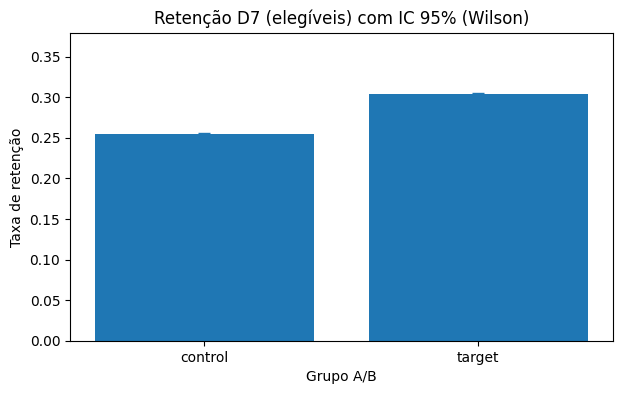

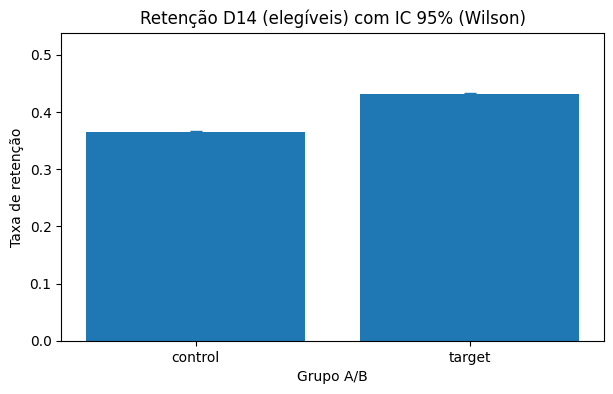

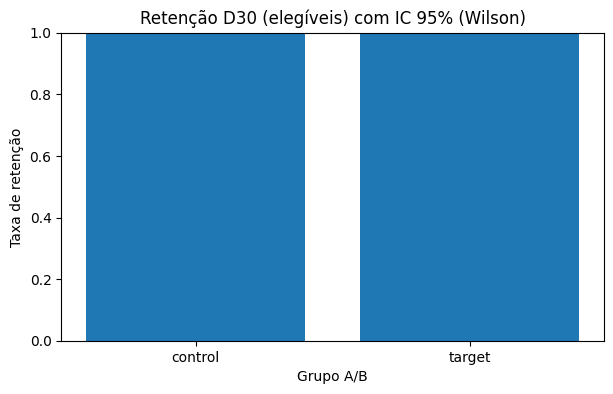

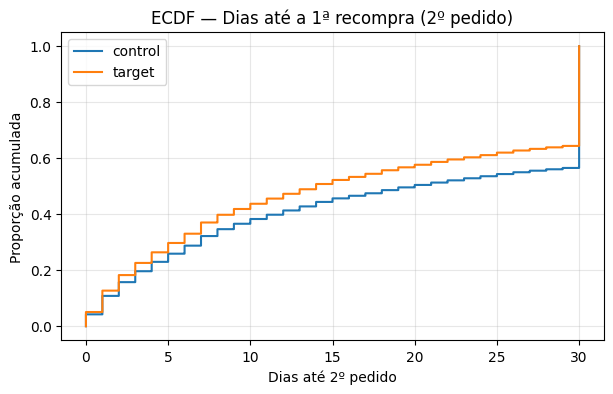

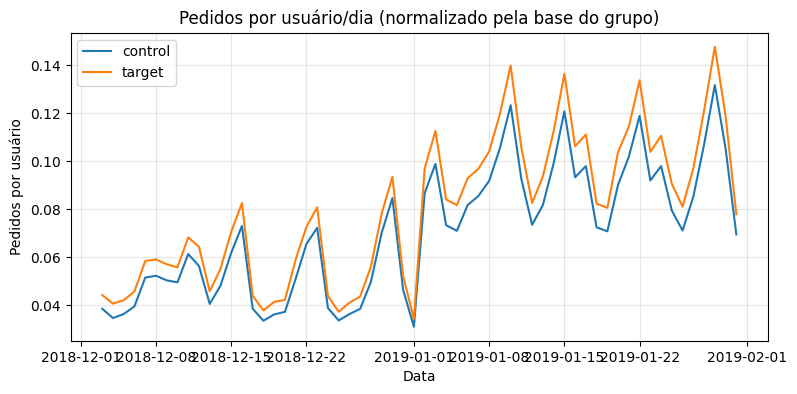

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import functions as F

# ---- 1) Retenção com IC
def plot_retention_with_ci(df, horizon):
    d = df[df["horizon_days"] == horizon].copy()

    # Ordem consistente (control -> target) se existir
    d["group"] = d["is_target"].astype(str)
    preferred_order = ["control", "target"]
    d["_order"] = d["group"].str.lower().apply(lambda g: preferred_order.index(g) if g in preferred_order else 99)
    d = d.sort_values("_order").drop(columns=["_order"])

    # Use taxa calculada por contagens para garantir consistência e evitar drift numérico
    n = d["n_eligible"].astype(float).values
    x = d["n_retained"].astype(float).values
    y = np.divide(x, n, out=np.zeros_like(x, dtype=float), where=n>0)

    ci_low = d["retention_ci_low"].astype(float).values
    ci_high = d["retention_ci_high"].astype(float).values

    # Sanitização: garante domínios e evita erro de yerr negativo por arredondamento
    y = np.clip(y, 0.0, 1.0)
    ci_low = np.clip(ci_low, 0.0, 1.0)
    ci_high = np.clip(ci_high, 0.0, 1.0)

    yerr_low = np.maximum(0.0, y - ci_low)
    yerr_high = np.maximum(0.0, ci_high - y)
    yerr = np.vstack([yerr_low, yerr_high])

    x_pos = np.arange(len(d))

    plt.figure(figsize=(7, 4))
    plt.bar(x_pos, y)
    plt.errorbar(x_pos, y, yerr=yerr, fmt="none", capsize=4)
    plt.xticks(x_pos, d["group"].values, rotation=0)
    plt.ylim(0, min(1.0, (max(y) * 1.25) if len(y) else 1.0))
    plt.title(f"Retenção D{horizon} (elegíveis) com IC 95% (Wilson)")
    plt.ylabel("Taxa de retenção")
    plt.xlabel("Grupo A/B")
    plt.show()

for h in [7, 14, 30]:
    plot_retention_with_ci(retention_summary, h)

# ---- 2) ECDF dias até 2º pedido (amostra para evitar estouro de memória)
sample_frac = 0.20
pdf_days = df_user_ab.select("is_target", "days_to_2nd") \
    .where(F.col("days_to_2nd").isNotNull()) \
    .sample(withReplacement=False, fraction=sample_frac, seed=42) \
    .toPandas()

plt.figure(figsize=(7,4))
for grp, sub in pdf_days.groupby(pdf_days["is_target"].astype(str)):
    vals = np.sort(sub["days_to_2nd"].values)
    ecdf = np.arange(1, len(vals)+1)/len(vals)
    plt.step(vals, ecdf, where="post", label=grp)

plt.title("ECDF — Dias até a 1ª recompra (2º pedido)")
plt.xlabel("Dias até 2º pedido")
plt.ylabel("Proporção acumulada")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ---- 3) Série temporal normalizada (orders per user/day)
ab_sizes = df_ab.groupBy("is_target").agg(F.countDistinct("customer_id").alias("n_users")).toPandas()
ab_size_map = {str(r["is_target"]): int(r["n_users"]) for _, r in ab_sizes.iterrows()}

df_daily = df_orders.withColumn("order_date", F.to_date("order_created_at")) \
    .join(df_ab.select("customer_id", "is_target"), on="customer_id", how="inner") \
    .groupBy("order_date", "is_target") \
    .agg(F.count("*").alias("n_orders")) \
    .toPandas()

df_daily["is_target"] = df_daily["is_target"].astype(str)
df_daily["orders_per_user"] = df_daily.apply(lambda r: r["n_orders"] / ab_size_map.get(r["is_target"], np.nan), axis=1)
df_daily.sort_values("order_date", inplace=True)

plt.figure(figsize=(9,4))
for grp, sub in df_daily.groupby("is_target"):
    plt.plot(sub["order_date"], sub["orders_per_user"], label=grp)

plt.title("Pedidos por usuário/dia (normalizado pela base do grupo)")
plt.xlabel("Data")
plt.ylabel("Pedidos por usuário")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### Leitura dos gráficos de retenção e tempo até recompra

**Resultado principal (métrica primária — retenção):**
- **D7:** Control **25,43%** vs Target **30,36%** ⇒ **+4,94 pp** (≈ **+19,4%** relativo). p-value ~ 0 (diferença altamente significativa).
- **D14:** Control **36,49%** vs Target **43,09%** ⇒ **+6,60 pp** (≈ **+18,1%** relativo). p-value ~ 0 (altamente significativo).
- **D30:** ambos ~ **100%** (métrica saturada nesta base ativa), diferença **não significativa** (p ≈ 0,255).  
  **Interpretação:** D30 não discrimina bem porque quase todos os usuários elegíveis já recompram dentro de 30 dias na janela observada (base muito ativa).

**O que isso sugere (negócio):**
- O cupom está associado a **acelerar a recompra** e **aumentar a frequência no curto prazo (7–14 dias)**.
- Como D30 está saturado, a análise deve se concentrar em **D7/D14**, **tempo até recompra** e **valor incremental**, e não em “retenção D30” como critério único.

> Observação metodológica: como os dados cobrem dez/18–jan/19, usamos elegibilidade (censura à direita) — só entra em Dk quem tem janela completa até `max_data − k`.


#3. Analise Exploratória

Esta seção é explicativa: investiga distribuição (cauda), ticket, séries temporais e qualidade de campos (ex.: descontos).
Ela não substitui a métrica primária (retenção), mas ajuda a entender como e onde o efeito aparece.

## 3.1 Criação de dataframe unificado para EDA

In [12]:
from pyspark.sql import functions as F

# 1. Join e Cache (para não reprocessar)
df_joined_full = df_orders.join(
    df_ab,
    df_orders.customer_id.cast("string") == df_ab['customer_id'].cast("string"),
    "inner"
).cache()

# 2. Verifica se o join funcionou
count_join = df_joined_full.count()
print(f"Total de linhas após o Join: {count_join}")

if count_join == 0:
    print("ERRO CRÍTICO: O Join resultou em 0 linhas. Verifique se os IDs estão formatados iguais (ex: UUIDs).")
else:
    print("Sucesso! Podemos gerar os gráficos.")

Total de linhas após o Join: 3662321
Sucesso! Podemos gerar os gráficos.


## 3.2 Distribuição dos valores de pedidos

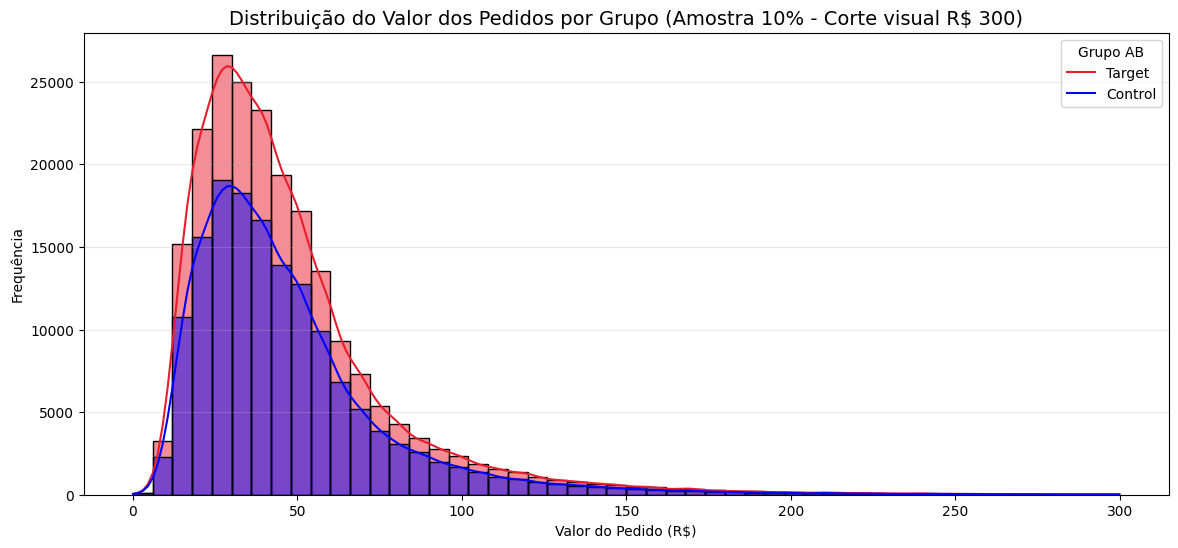

In [13]:
# Célula de Preparação Segura
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Amostragem: Pegamos 10% dos dados do df_joined_full para não sobrecarregar a memória RAM ao plotar
# df_joined_full já contém os dados de pedidos e a informação do grupo A/B (is_target)
df_gmv_sample_ab = df_joined_full.select("order_total_amount", "is_target") \
                                 .sample(fraction=0.1, seed=42) \
                                 .toPandas()

# 2. Plotagem com separação por grupo (Control vs Target)
plt.figure(figsize=(14, 6))

# Filtrando visualmente outliers extremos (> R$ 300) para o gráfico ficar legível
sns.histplot(data=df_gmv_sample_ab[df_gmv_sample_ab['order_total_amount'] < 300],
             x='order_total_amount',
             hue='is_target', # Adiciona a separação por grupo A/B
             bins=50, kde=True, palette={'control': 'blue', 'target': '#ea1d2c'})

plt.title('Distribuição do Valor dos Pedidos por Grupo (Amostra 10% - Corte visual R$ 300)', fontsize=14)
plt.xlabel('Valor do Pedido (R$)')
plt.ylabel('Frequência')
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Grupo AB', labels=['Target', 'Control']) # Ajuste a ordem da legenda se necessário
plt.show()

### Leitura do histograma (distribuição do valor do pedido)

- A distribuição mostra o comportamento esperado de marketplace: **muitos pedidos de baixo valor** e uma **cauda longa** (outliers altos).  
- O gráfico aplica um **corte visual em R$ 300** apenas para legibilidade; não removemos outliers da análise numérica.
- A sobreposição entre grupos é alta, indicando que a campanha **não muda radicalmente o “perfil” do ticket por pedido**.  
  O impacto observado no A/B tende a vir mais de **frequência/recompra** do que de aumento do valor unitário do pedido.

Próximo passo (se quisermos mais robustez): comparar também **mediana**, **percentis (p50/p75/p90)** e/ou usar **log(valor)** para visualizar melhor a cauda.


## 3.3 Comparativo de Tickets Médios

/tmp/ipython-input-3695469166.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Grupo', y='avg_ticket', data=df_ticket_medio,


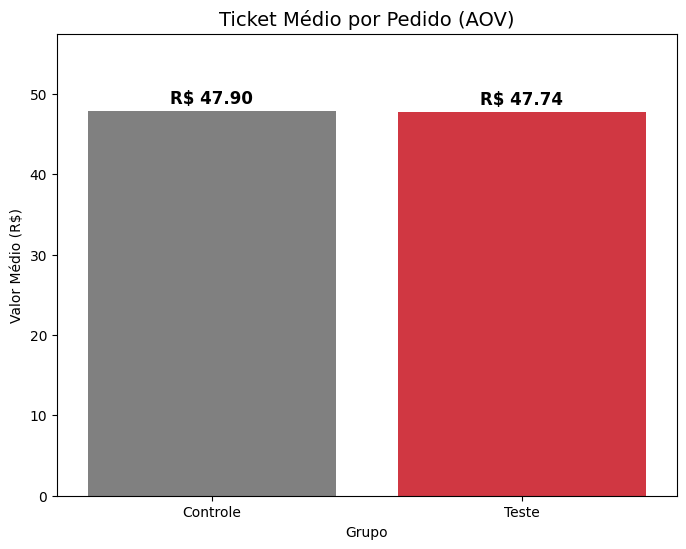

In [14]:
# Célula Nova: Comparativo de Ticket Médio (AOV)
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# 1. Agregação: Média de valor POR PEDIDO
df_ticket_medio = df_joined_full.groupBy("is_target") \
                                .agg(F.avg("order_total_amount").alias("avg_ticket"),
                                     F.stddev("order_total_amount").alias("std_ticket"),
                                     F.count("order_id").alias("vol_pedidos")) \
                                .toPandas()

# 2. Tratamento Estético
df_ticket_medio['Grupo'] = df_ticket_medio['is_target'].map({'control': 'Controle', 'target': 'Teste'})
df_ticket_medio['avg_ticket'] = df_ticket_medio['avg_ticket'].astype(float)

# 3. Visualização
plt.figure(figsize=(8, 6))

# Usamos barplot simples. Como já calculamos a média, passamos y=avg_ticket
ax = sns.barplot(x='Grupo', y='avg_ticket', data=df_ticket_medio,
                 palette=['gray', '#ea1d2c'], capsize=.1)

# Adicionando os valores nas barras para facilitar a leitura executiva
for p in ax.patches:
    ax.annotate(f'R$ {p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points',
                fontsize=12, fontweight='bold')

plt.title('Ticket Médio por Pedido (AOV)', fontsize=14)
plt.ylabel('Valor Médio (R$)')
plt.ylim(0, df_ticket_medio['avg_ticket'].max() * 1.2) # Dá um respiro no topo
plt.show()

### Leitura do gráfico de ticket médio (AOV)

Pelo comparativo de AOV, o efeito do cupom **não aparece como um grande aumento de ticket por pedido**.

Isso é consistente com o padrão de promoções:
- cupons podem **estimular pedidos adicionais** (frequência),  
- mas o usuário pode compensar com carrinhos um pouco menores (AOV “flat” ou levemente menor).

**Checagem rápida (ordem de grandeza):** nos horizontes D7/D14, `GMV por usuário` e `pedidos por usuário` sobem no Target, enquanto o quociente (≈ AOV) tende a ficar próximo — sugerindo que o ganho vem principalmente de **mais pedidos por usuário**.


## 3.4 Evolução temporal dos pedidos

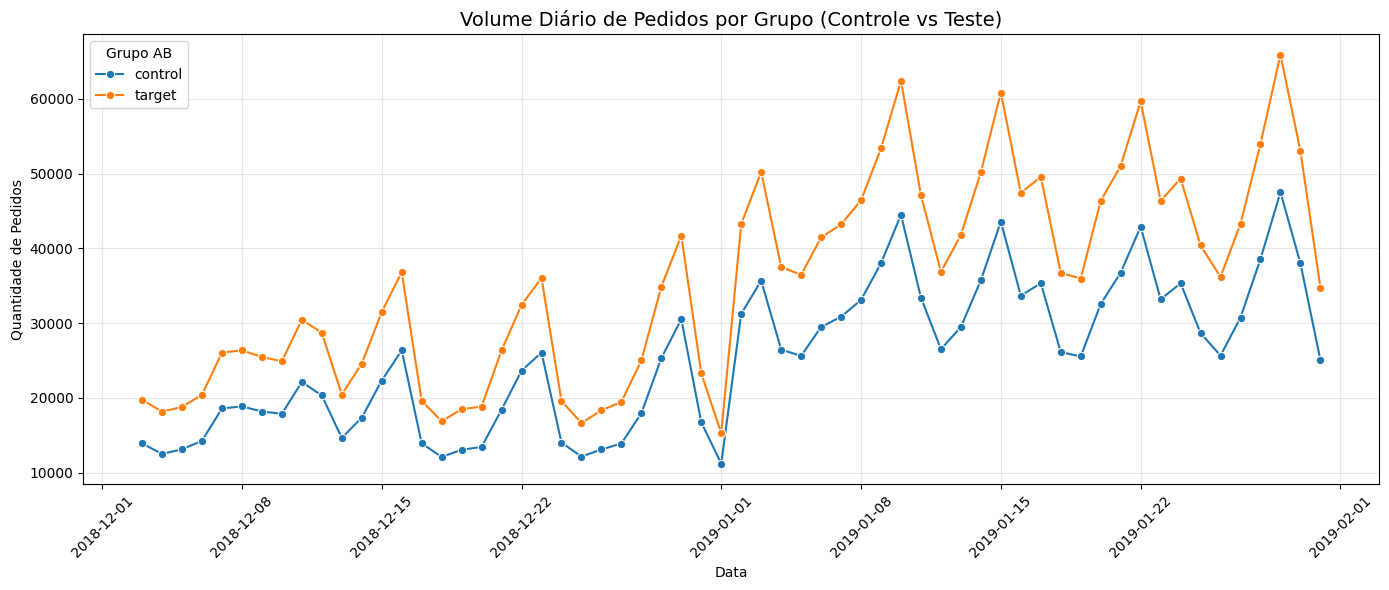

In [15]:
# Célula Nova: Evolução Temporal dos Pedidos por Grupo (Controle vs Teste)
from pyspark.sql.functions import to_date, count
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Agregação no Spark (Super Rápido)
# Convertendo timestamp para data e contando pedidos por dia e por grupo
df_daily_ab = df_joined_full.withColumn("order_date", to_date("order_created_at")) \
                    .groupBy("order_date", "is_target") \
                    .agg(count("order_id").alias("total_orders")) \
                    .orderBy("order_date", "is_target") \
                    .toPandas()

# 2. Plotagem
plt.figure(figsize=(14, 6))

sns.lineplot(data=df_daily_ab, x='order_date', y='total_orders', hue='is_target', marker='o')

plt.title('Volume Diário de Pedidos por Grupo (Controle vs Teste)', fontsize=14)
plt.xlabel('Data')
plt.ylabel('Quantidade de Pedidos')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend(title='Grupo AB')
plt.tight_layout()
plt.show()

### Leitura da série temporal (pedidos por usuário/dia)

- Aqui normalizamos por base (`pedidos / usuários do grupo`) para evitar comparar apenas volume bruto.
- Um Target consistentemente acima do Control ao longo do período reforça que o efeito observado em médias **não é só artefato do tamanho do grupo**.

Limitações (para não super-interpretar):
- Sem uma marcação explícita de “pré” e “pós” (data de início do tratamento), esta série serve mais como **diagnóstico** do que como prova causal diária.
- Há sazonalidade natural (fim de ano / janeiro) que pode afetar níveis absolutos — por isso o foco final fica em métricas agregadas do experimento.


##3.5 Comportamento dos descontos

Podemos observar que os valores de descontos para todos os pedidos estão zerados.

**Interpretação:** O comportamento observado nos valores de descontos pode ser interpretado como uma falha de captura e/ou disponibilização destes dados, visto que, para tamanho número de pedidos, é altamente improvável que nenhum pedido utilizou-se de algum desconto. Outra interpretação é de que o comportamento é proposital para que o analista seja induzido a assumir uma premissa para viabilizar uma análise financeira do impacto do teste A/B.

In [17]:
# Range de descontos aplicados por cupons

df_orders.select("order_id", "order_total_amount", "order_created_at", F.expr("aggregate(items_parsed.totalDiscount.value,cast(0 as double),(acc,x) -> acc + x)").alias("order_discount")) \
  .select(F.max("order_discount").alias("max_discount"), F.min("order_discount").alias("min_discount"))

max_discount,min_discount
0.0,0.0


##3.6 Relação espacial e temporal dos pedidos

Podemos observar que os dados de latitude e longitude do local do cliente e do restaurante são idênticos, resultando em distância 0. Os dados sobre o tempo de entrega dos restaurantes também é majoritariamente 0.

**Interpretação:** O comportamento visto nestes dados indica que estas informações não possuem grande relevância para este case. Caso estas informações espaciais estivessem disponíveis, análises e sugestões espaciais poderiam ser geradas, como: Ticket Médio x Tempo de Entrega; Ticket Médio x Distância, etc.

In [18]:
# Função para calcular distância Haversine em KM
def haversine_distance(lat1, lon1, lat2, lon2):
    return F.acos(
        F.sin(F.radians(lat1)) * F.sin(F.radians(lat2)) +
        F.cos(F.radians(lat1)) * F.cos(F.radians(lat2)) * F.cos(F.radians(lon2) - F.radians(lon1))
    ) * F.lit(6371)

# Adicionando distância e tempo de entrega à análise
df_geo_analysis = df_orders.join(df_restaurants.select("id", "delivery_time"),
                                df_orders.merchant_id == df_restaurants.id) \
    .withColumn("distancia_km", haversine_distance(
        F.col("delivery_address_latitude"), F.col("delivery_address_longitude"),
        F.col("merchant_latitude"), F.col("merchant_longitude")
    ))

distance_quartiles = df_geo_analysis.approxQuantile("distancia_km", [0.25, 0.5, 0.75], 0.01)

print("--- Distance Quartiles (km) ---")
print(f"25th percentile (Q1): {distance_quartiles[0]:.2f} km")
print(f"50th percentile (Median/Q2): {distance_quartiles[1]:.2f} km")
print(f"75th percentile (Q3): {distance_quartiles[2]:.2f} km")

print("-" * 30)

delivery_quartiles = df_geo_analysis.approxQuantile("delivery_time", [0.25, 0.5, 0.75], 0.01)

print("--- Delivery Quartiles (minutos) ---")
print(f"25th percentile (Q1): {delivery_quartiles[0]:.2f} minutos")
print(f"50th percentile (Median/Q2): {delivery_quartiles[1]:.2f} minutos")
print(f"75th percentile (Q3): {delivery_quartiles[2]:.2f} minutos")

--- Distance Quartiles (km) ---
25th percentile (Q1): 0.00 km
50th percentile (Median/Q2): 0.00 km
75th percentile (Q3): 0.00 km
------------------------------
--- Delivery Quartiles (minutos) ---
25th percentile (Q1): 0.00 minutos
50th percentile (Median/Q2): 0.00 minutos
75th percentile (Q3): 0.00 minutos


#4. Feature Engineering

##4.1 Métricas utilizadas para basear a segmentação

Para uma visão 360º do cliente, a análise não se limitou apenas ao histórico de compras, mas integrou três dimensões críticas:


### **RFM (Recency, Frequency, Monetary)**:
Baseado nos dados de pedidos (order.json), esta métrica mensura o comportamento transacional puro.

1. **Recência**: Dias desde o último pedido em relação ao snapshot da base.


2. **Frequência**: Quantidade total de pedidos realizados.


3. **Monetário**: Valor total transacionado pelo usuário (GMV).


###**Perfil de Bolso (Sensibilidade a Preço)**:
Calculado com base no ticket médio dos pedidos e dividido em quartis.

* **Econômico**: Usuários cujos gastos médios por pedido estão no primeiro quartil (mais baixos).

* **Moderado**: Usuários situados na média de gastos da base.

* **Premium**: Usuários com ticket médio elevado (quarto quartil), indicando menor sensibilidade ao valor nominal e maior busca por conveniência ou qualidade.


###**Ciclo de Vida:**
Classifica o usuário com base no tempo decorrido desde o seu cadastro.

* **Novo**: Clientes com menos de 60 dias de plataforma. O foco aqui é a conversão em hábito.

* **Veterano**: Clientes com mais de 60 dias. O foco é a retenção e prevenção de churn.

A segmentação é usada para:

* Identificar heterogeneidade de impacto (quem responde melhor ao cupom);
* Orientar targeting e política de incentivo (eficiência financeira).

In [19]:
# --- ETAPA 1: SEGMENTAÇÃO COMPLETA (RFM + BOLSO + CICLO) ---
from pyspark.sql.window import Window

# Data de referência (Snapshot)
max_date = df_orders.select(F.max("order_created_at")).collect()[0][0]

# --- A. CÁLCULO RFM ---
df_rfm = df_orders.groupBy("customer_id").agg(
    F.max("order_created_at").alias("last_purchase"),
    F.count("order_id").alias("frequency"),
    F.sum("order_total_amount").alias("monetary")
).withColumn("recency", F.datediff(F.lit(max_date), F.col("last_purchase")))

# Quartis RFM
df_rfm = df_rfm \
    .withColumn("R_Score", F.ntile(4).over(Window.orderBy(F.desc("recency")))) \
    .withColumn("F_Score", F.ntile(4).over(Window.orderBy("frequency"))) \
    .withColumn("M_Score", F.ntile(4).over(Window.orderBy("monetary")))

df_rfm_labeled = df_rfm.withColumn("segmento_rfm",
    F.when((F.col("R_Score") == 4) & (F.col("F_Score") == 4), "Champions")
    .when((F.col("F_Score") >= 3), "Leais")
    .when((F.col("R_Score") == 4) & (F.col("F_Score") <= 2), "Promissores")
    .when((F.col("R_Score") <= 2) & (F.col("F_Score") >= 3), "Em Risco")
    .when((F.col("R_Score") <= 2) & (F.col("F_Score") <= 2), "Hibernando")
    .otherwise("Precisa de Atenção")
)

# --- B. PERFIL DE BOLSO (Price Sensitivity) ---
df_orders_rest = df_orders.join(df_restaurants.withColumnRenamed("id", "merchant_id"), on="merchant_id", how="left")
df_pocket = df_orders_rest.groupBy("customer_id").agg(F.mean("order_total_amount").alias("avg_ticket"))

df_pocket = df_pocket.withColumn("ticket_quartile", F.ntile(4).over(Window.orderBy("avg_ticket"))) \
    .withColumn("perfil_bolso",
        F.when(F.col("ticket_quartile") == 1, "Econômico")
        .when(F.col("ticket_quartile") == 4, "Premium")
        .otherwise("Moderado")
    )

# --- C. CICLO DE VIDA ---
df_lifecycle = df_consumers.select("customer_id", "created_at") \
    .withColumn("days_since_reg", F.datediff(F.lit(max_date), F.col("created_at"))) \
    .withColumn("ciclo_vida", F.when(F.col("days_since_reg") <= 60, "Novo").otherwise("Veterano"))

# --- D. UNIFICAÇÃO E GRAVAÇÃO ---
df_segmentation_final = df_rfm_labeled.select("customer_id", "segmento_rfm", "frequency", "monetary") \
    .join(df_pocket.select("customer_id", "perfil_bolso"), on="customer_id", how="left") \
    .join(df_lifecycle.select("customer_id", "ciclo_vida"), on="customer_id", how="left") \
    .fillna("Desconhecido")

print("Salvando Tabela de Segmentação em Specialized...")
df_segmentation_final.write.mode("overwrite").parquet(os.path.join(DIRS["SPECIALIZED"], "customer_profiles"))
df_segmentation_final.show(5)

Salvando Tabela de Segmentação em Specialized...
+--------------------+------------+---------+--------+------------+----------+
|         customer_id|segmento_rfm|frequency|monetary|perfil_bolso|ciclo_vida|
+--------------------+------------+---------+--------+------------+----------+
|16590db8a1ea48f92...|  Hibernando|        1|    40.2|    Moderado|  Veterano|
|1e4013599bdcb9ade...|  Hibernando|        1|    36.9|    Moderado|  Veterano|
|388f6bb7974f6e1e8...|  Hibernando|        1|    27.5|   Econômico|  Veterano|
|75ab2313a17831bc3...|  Hibernando|        1|    54.0|    Moderado|  Veterano|
|7f0f2f4b87a1b7fb5...|  Hibernando|        1|    26.0|   Econômico|  Veterano|
+--------------------+------------+---------+--------+------------+----------+
only showing top 5 rows



##4.2 Significado das segmentações do RFM

Para atribuir os segmentos, a base foi dividida em quartis de 1 a 4 para cada métrica RFM, resultando nas seguintes classificações:

* **Champions (R=4, F=4)**: São os melhores clientes. Compram com alta frequência e de forma muito recente. Devem ser recompensados com programas de fidelidade, mas cupons agressivos aqui podem gerar canibalização de margem, já que eles já possuem o hábito consolidado.

* **Leais (F >= 3)**: Clientes recorrentes que mantêm o volume da plataforma. São o público-alvo para estratégias de aumento de ticket médio (upsell).

* **Promissores (R=4, F <= 2)**: Clientes que realizaram pedidos recentemente, mas ainda não têm alta frequência. Representam a maior oportunidade de crescimento; o cupom aqui serve como incentivo para a criação de recorrência.

* **Em Risco (R <= 2, F >= 3)**: Clientes que eram frequentes, mas não compram há algum tempo. É o grupo crítico para campanhas de reativação, onde o investimento em marketing (cupom) visa evitar a perda definitiva do cliente.

* **Hibernando (R <= 2, F <= 2)**: Clientes com baixa frequência e que não aparecem há tempo. O custo de reaquecimento pode ser alto, exigindo ofertas mais agressivas ou análise de causa de abandono (churn).

* **Precisa de Atenção**: Usuários que não se encaixam nos extremos, mas demonstram comportamento de compra inconstante.

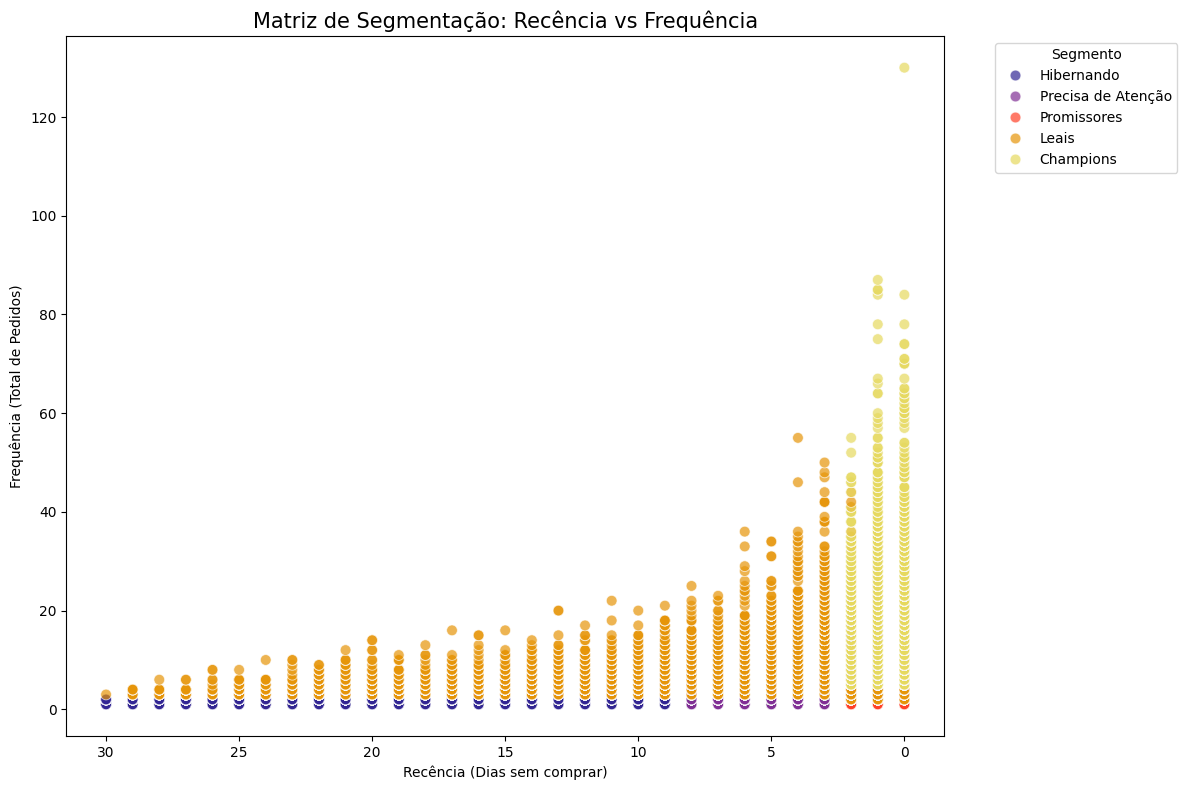

In [20]:
# Célula Nova: Visualização dos Clusters RFM
# Vamos pegar uma amostra de 5% dos clientes para o gráfico não virar uma "mancha" ilegível
df_rfm_viz = df_rfm_labeled.select("recency", "frequency", "segmento_rfm") \
                   .sample(fraction=0.05, seed=42) \
                   .toPandas()

plt.figure(figsize=(12, 8))

# Scatterplot cruzando Recência vs Frequência, colorido pelo Segmento
sns.scatterplot(data=df_rfm_viz, x='recency', y='frequency', hue='segmento_rfm', alpha=0.7, palette='CMRmap', s=60)

plt.title('Matriz de Segmentação: Recência vs Frequência', fontsize=15)
plt.xlabel('Recência (Dias sem comprar)')
plt.ylabel('Frequência (Total de Pedidos)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Segmento')

# Invertemos o eixo X porque Recência menor (0) é melhor
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()

### Leitura do scatter de clusters RFM

Este gráfico ajuda a visualizar **heterogeneidade**:
- clusters com **recência baixa + alta frequência** tendem a representar usuários **engajados/fiéis**;
- clusters com **recência alta + baixa frequência** tendem a ser **reativáveis** (bom alvo para cupom).

Como usar isso no plano de ação:
- medir **lift de retenção/GMV por segmento** e priorizar cupom onde o ROI for maior;
- evitar “subsidiar” usuários já muito engajados, onde o cupom pode virar **custo sem incrementalidade**.


## 4.3 A/B — Métricas secundárias, variabilidade e leitura de negócio

Nesta etapa, usamos uma **master table** (AB + métricas de compra + segmentos) para:
- comparar GMV/usuário e pedidos/usuário,
- observar variabilidade (boxplot),
- aprofundar a discussão de unit economics e viabilidade.


In [21]:
# --- ETAPA 2: PREPARAÇÃO DA BASE ANALÍTICA (AB TEST MASTER TABLE) ---

# 1. Carregar tabelas
# df_ab = spark.read.parquet(os.path.join(DIRS["CURATED"], "ab_test"))
df_seg = spark.read.parquet(os.path.join(DIRS["SPECIALIZED"], "customer_profiles"))

# 2. Pré-agregar Pedidos por Usuário (CRUCIAL para evitar duplicação)
# Transforma N pedidos em 1 linha de resumo por cliente
df_user_metrics = df_orders.groupBy("customer_id").agg(
    F.count("order_id").alias("qtd_pedidos"),
    F.sum("order_total_amount").alias("gmv_total")
)

# 3. Join Final: AB Test (Base) + Metricas de Compra + Segmentos
df_analytics_master = df_ab \
    .join(df_user_metrics, on="customer_id", how="left") \
    .join(df_seg, on="customer_id", how="left") \
    .fillna(0, subset=["qtd_pedidos", "gmv_total"]) \
    .fillna("Desconhecido", subset=["segmento_rfm", "perfil_bolso", "ciclo_vida"]) \
    .withColumn("comprou", F.when(F.col("qtd_pedidos") > 0, 1).otherwise(0))

# Cache para performance nas análises seguintes
df_analytics_master.cache()

print("Base Analítica pronta. Total de Usuários no Teste:", df_analytics_master.count())

Base Analítica pronta. Total de Usuários no Teste: 806467


In [23]:
from scipy import stats

# 1. Extrair as distribuições de GMV para cada grupo
gmv_target = df_analytics_master.filter("is_target = 'target'").select("gmv_total").toPandas()["gmv_total"]
gmv_control = df_analytics_master.filter("is_target = 'control'").select("gmv_total").toPandas()["gmv_total"]

# 2. Executar o Teste t (Independente)
t_stat, p_val = stats.ttest_ind(gmv_target, gmv_control, equal_var=False)

print(f"Estatística t: {t_stat:.4f}")
print(f"P-Valor: {p_val:.8f}")

if p_val < 0.05:
    print("Resultado estatisticamente significativo (p < 0.05). Rejeitamos a hipótese nula.")
else:
    print("Não há evidência estatística de que o cupom alterou o gasto. O resultado pode ser fruto do acaso.")

Estatística t: 24.3129
P-Valor: 0.00000000
Resultado estatisticamente significativo (p < 0.05). Rejeitamos a hipótese nula.


/tmp/ipython-input-1363167356.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Nome_Grupo', y='gmv_total', data=df_ab_viz, showfliers=False, palette="Set2")


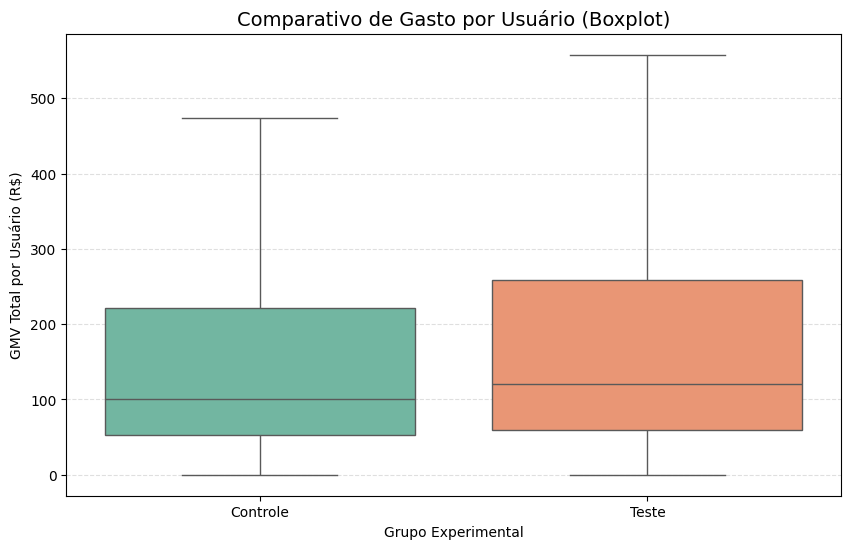

In [24]:
# Célula Nova: Boxplot Controle vs Teste
# Utilizando o df_analytics_master que você criou na etapa 4.2

# Selecionamos apenas as colunas de grupo e métrica de interesse
# group_id: 0 = Controle, 1 = Teste (ajuste conforme sua coluna real)
df_ab_viz = df_analytics_master.select("is_target", "gmv_total") \
                               .sample(fraction=0.2, seed=42) \
                               .toPandas()

# Mapeando 0 e 1 para nomes legíveis (Opcional, depende de como está no seu DF)
df_ab_viz['Nome_Grupo'] = df_ab_viz['is_target'].map({'control': 'Controle', 'target': 'Teste'})

plt.figure(figsize=(10, 6))

# showfliers=False remove os outliers extremos do visual para focar na caixa principal (quartis)
sns.boxplot(x='Nome_Grupo', y='gmv_total', data=df_ab_viz, showfliers=False, palette="Set2")

plt.title('Comparativo de Gasto por Usuário (Boxplot)', fontsize=14)
plt.xlabel('Grupo Experimental')
plt.ylabel('GMV Total por Usuário (R$)')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

### Leitura do boxplot (GMV/usuário: dispersão e outliers)

- O boxplot evidencia **dispersão alta** e presença de **outliers** (cauda pesada).
- Isso é importante porque médias podem ser puxadas por poucos usuários de altíssimo gasto.

Recomendação analítica:
- complementar com **mediana** e **IC via bootstrap** (ou médias aparadas/trimming) para validar robustez do efeito.
- reportar também **efeito absoluto** (Δ R$ por usuário) e não só significância estatística.


## 4.4 Viabilidade financeira e decisão (cenários)

Como o dataset pode não conter o “desconto efetivo” por pedido de forma confiável, avaliamos **cenários** de custo e taxa de resgate.

Framework:
- **GMV incremental total** ≈ (média GMV/user target − média GMV/user control) × N_users_target
- **Margem incremental** = take_rate × GMV_incremental_total
- **Custo cupons** = custo_cupom × (total_pedidos_target) × taxa_resgate
- **ROI** = (margem_incremental − custo_cupons) / custo_cupons


In [25]:
import itertools
import pandas as pd
from pyspark.sql import functions as F

# métricas por grupo no nível usuário (df_user_ab) + total de pedidos
user_metrics = df_user_ab.groupBy("is_target").agg(
    F.countDistinct("customer_id").alias("n_users"),
    F.avg("gmv_user").alias("avg_gmv_user"),
    F.avg("orders_user").alias("avg_orders_user"),
    F.sum("orders_user").alias("total_orders"),
    F.sum("gmv_user").alias("total_gmv")
).toPandas()

user_metrics["is_target"] = user_metrics["is_target"].astype(str)
display(user_metrics)

def get_row(df, label):
    return df.loc[df["is_target"].str.lower()==label, :].iloc[0]

target_label = "target"
control_label = "control"

t = get_row(user_metrics, target_label)
c = get_row(user_metrics, control_label)

incremental_gmv_per_user = float(t["avg_gmv_user"] - c["avg_gmv_user"])
n_target_users = int(t["n_users"])
incremental_gmv_total = incremental_gmv_per_user * n_target_users
total_orders_target = float(t["total_orders"])

# Retenção D30 (se calculada)
ret30 = retention_summary[retention_summary["horizon_days"]==30].copy()
ret30["is_target"] = ret30["is_target"].astype(str)
if set(ret30["is_target"].str.lower()) >= set([target_label, control_label]):
    rt = float(ret30.loc[ret30["is_target"].str.lower()==target_label, "retention_rate"].values[0])
    rc = float(ret30.loc[ret30["is_target"].str.lower()==control_label, "retention_rate"].values[0])
    retention_lift_pp = (rt - rc) * 100
else:
    retention_lift_pp = None

TAKE_RATE = 0.15
coupon_costs = [5.0, 10.0, 15.0]
redeem_rates = [0.2, 0.4, 0.6, 0.8, 1.0]

scenario_rows = []
for cc, rr in itertools.product(coupon_costs, redeem_rates):
    margin_inc = TAKE_RATE * incremental_gmv_total
    coupon_cost_total = cc * total_orders_target * rr
    net = margin_inc - coupon_cost_total
    roi = (net / coupon_cost_total) if coupon_cost_total > 0 else None
    scenario_rows.append({
        "take_rate": TAKE_RATE,
        "coupon_cost_per_order": cc,
        "redeem_rate_target": rr,
        "incremental_gmv_per_user": incremental_gmv_per_user,
        "n_target_users": n_target_users,
        "incremental_gmv_total": incremental_gmv_total,
        "incremental_margin": margin_inc,
        "coupon_cost_total": coupon_cost_total,
        "net_impact": net,
        "roi": roi,
        "retention_lift_D30_pp": retention_lift_pp
    })

scenarios = pd.DataFrame(scenario_rows).sort_values(["coupon_cost_per_order","redeem_rate_target"])
display(scenarios)

executive = pd.DataFrame([{
    "avg_gmv_user_target": float(t["avg_gmv_user"]),
    "avg_gmv_user_control": float(c["avg_gmv_user"]),
    "incremental_gmv_per_user": incremental_gmv_per_user,
    "n_target_users": n_target_users,
    "incremental_gmv_total": incremental_gmv_total,
    "take_rate": TAKE_RATE,
    "incremental_margin": TAKE_RATE * incremental_gmv_total,
    "total_orders_target": total_orders_target,
    "retention_lift_D30_pp": retention_lift_pp
}])

display(executive)


,is_target,n_users,avg_gmv_user,avg_orders_user,total_orders,total_gmv
0,control,360542,202.672290,4.231341,1525576,7.307187e+07
1,target,445924,228.755505,4.791725,2136745,1.020076e+08


,take_rate,coupon_cost_per_order,redeem_rate_target,incremental_gmv_per_user,n_target_users,incremental_gmv_total,incremental_margin,coupon_cost_total,net_impact,roi,retention_lift_D30_pp
0,0.15,5.0,0.2,26.083215,445924,1.163113e+07,1.744670e+06,2136745.0,-3.920753e+05,-0.183492,0.000414
1,0.15,5.0,0.4,26.083215,445924,1.163113e+07,1.744670e+06,4273490.0,-2.528820e+06,-0.591746,0.000414
2,0.15,5.0,0.6,26.083215,445924,1.163113e+07,1.744670e+06,6410235.0,-4.665565e+06,-0.727831,0.000414
3,0.15,5.0,0.8,26.083215,445924,1.163113e+07,1.744670e+06,8546980.0,-6.802310e+06,-0.795873,0.000414
4,0.15,5.0,1.0,26.083215,445924,1.163113e+07,1.744670e+06,10683725.0,-8.939055e+06,-0.836698,0.000414
5,0.15,10.0,0.2,26.083215,445924,1.163113e+07,1.744670e+06,4273490.0,-2.528820e+06,-0.591746,0.000414
6,0.15,10.0,0.4,26.083215,445924,1.163113e+07,1.744670e+06,8546980.0,-6.802310e+06,-0.795873,0.000414
7,0.15,10.0,0.6,26.083215,445924,1.163113e+07,1.744670e+06,12820470.0,-1.107580e+07,-0.863915,0.000414
8,0.15,10.0,0.8,26.083215,445924,1.163113e+07,1.744670e+06,17093960.0,-1.534929e+07,-0.897936,0.000414
9,0.15,10.0,1.0,26.083215,445924,1.163113e+07,1.744670e+06,21367450.0,-1.962278e+07,-0.918349,0.000414


,avg_gmv_user_target,avg_gmv_user_control,incremental_gmv_per_user,n_target_users,incremental_gmv_total,take_rate,incremental_margin,total_orders_target,retention_lift_D30_pp
0,228.755505,202.67229,26.083215,445924,1.163113e+07,0.15,1.744670e+06,2136745.0,0.000414


# 5. Recomendações e próximo desenho de teste (proposta)

**Recomendações (baseadas nos achados):**
- Direcionar cupom para segmentos com maior lift (ex.: RFM / ciclo de vida) para reduzir custo e canibalização.
- Monitorar guardrails: margem líquida, AOV, número de pedidos por usuário, CAC/reativação (se aplicável).

**Novo teste A/B (sugestão):**
- População-alvo: (ex.: “quase churn” / “novos” / baixa frequência) — definido por segmentação.
- Métrica primária: retenção D30 (ou D14) com janela completa; métricas secundárias: GMV/user, pedidos/user, AOV.
- Duração: garantir janela suficiente para medir D30 sem censura (ou usar survival).
- Instrumentação: garantir captura do **desconto efetivo** por pedido (coluna de desconto hoje pode estar zerada).


## Apêndice — Análises adicionais feitas durante sketching do notebook

As células abaixo foram mantidas para referência (análises pivotadas, cenários e visualizações adicionais).  


In [26]:
# --- ANÁLISE PIVOTADA: FOCO EM RENTABILIDADE E COMPORTAMENTO ---
# (Assumindo que Conversão não pode ser medida devido ao viés da base)

# Premissas
CUSTO_CUPOM = 10.00
TAKE_RATE = 0.15 # iFood fica com 15%

# 1. Preparar dados agregados
df_ab = spark.read.parquet(os.path.join(DIRS["CURATED"], "ab_test"))
df_orders = spark.read.parquet(os.path.join(DIRS["CURATED"], "orders"))

# Join para pegar apenas os pedidos do teste
df_analysis = df_ab.join(df_orders, on="customer_id", how="inner")

# 2. Calcular KPIs de Gasto
df_kpis = df_analysis.groupBy("is_target").agg(
    F.countDistinct("customer_id").alias("total_compradores"),
    F.count("order_id").alias("total_pedidos"),
    F.sum("order_total_amount").alias("gmv_total"),
    F.mean("order_total_amount").alias("ticket_medio")
).withColumn(
    "frequencia", F.col("total_pedidos") / F.col("total_compradores")
)

# 3. Trazer para Pandas e calcular o ROI
res = df_kpis.toPandas().set_index("is_target")

# Dados do Grupo Target
gmv_target = res.loc["target", "gmv_total"]
orders_target = res.loc["target", "total_pedidos"]
users_target = res.loc["target", "total_compradores"]
ticket_target = res.loc["target", "ticket_medio"]

# Dados do Grupo Control (Baseline)
ticket_control = res.loc["control", "ticket_medio"]
freq_control = res.loc["control", "frequencia"]

# --- CÁLCULO DE VIABILIDADE ---
# "Quanto a mais o iFood ganhou por pedido no Target comparado ao Controle?"

# Delta de Ticket Médio (Lift de Gasto por Pedido)
delta_ticket = ticket_target - ticket_control

# Receita Extra do iFood por Pedido (15% sobre o aumento do ticket)
receita_marginal_por_pedido = delta_ticket * TAKE_RATE

# Resultado por Pedido (Receita Extra - Custo do Cupom)
lucro_por_pedido = receita_marginal_por_pedido - CUSTO_CUPOM

print(f"--- ANÁLISE DE UNIT ECONOMICS (POR PEDIDO) ---")
print(f"Ticket Médio Controle: R$ {ticket_control:.2f}")
print(f"Ticket Médio Target:   R$ {ticket_target:.2f}")
print(f"Aumento no Ticket:     R$ {delta_ticket:.2f}")
print("-" * 30)
print(f"Comissão Extra (15%):  R$ {receita_marginal_por_pedido:.2f}")
print(f"Custo do Cupom:        R$ {CUSTO_CUPOM:.2f}")
print(f"Resultado Final:       R$ {lucro_por_pedido:.2f} por pedido")

if lucro_por_pedido < 0:
    print("\n[CONCLUSÃO]: A estratégia destrói valor. O aumento no ticket médio não cobre o custo do cupom.")
    print("Sugestão: O cupom só deve ser dado se houver um 'Mínimo de Compra' (ex: R$ 10 OFF acima de R$ 60).")

--- ANÁLISE DE UNIT ECONOMICS (POR PEDIDO) ---
Ticket Médio Controle: R$ 47.90
Ticket Médio Target:   R$ 47.74
Aumento no Ticket:     R$ -0.16
------------------------------
Comissão Extra (15%):  R$ -0.02
Custo do Cupom:        R$ 10.00
Resultado Final:       R$ -10.02 por pedido

[CONCLUSÃO]: A estratégia destrói valor. O aumento no ticket médio não cobre o custo do cupom.
Sugestão: O cupom só deve ser dado se houver um 'Mínimo de Compra' (ex: R$ 10 OFF acima de R$ 60).


In [27]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# --- 1. CONFIGURAÇÕES E PREMISSAS ---
TAKE_RATE = 0.15
CUSTO_CUPOM = 10.00

# --- 2. PREPARAÇÃO DOS DADOS (PANDAS) ---
# Agregação por Segmento e Grupo
df_segment_data = df_analytics_master.groupBy("segmento_rfm", "is_target").agg(
    F.count("customer_id").alias("n_users"),
    F.sum("qtd_pedidos").alias("total_orders"),
    F.sum("gmv_total").alias("total_gmv")
).toPandas()

# Pivotando de forma segura
pdf_pivot = df_segment_data.pivot(index='segmento_rfm', columns='is_target').fillna(0)

# Achatando colunas multinível para facilitar o acesso: 'n_users_target', 'total_gmv_control', etc.
pdf_pivot.columns = [f"{col}_{group}" for col, group in pdf_pivot.columns]

# --- 3. CÁLCULO DE INCREMENTALIDADE E ROI ---
# Removendo 'Desconhecido' se não houver dados em ambos os grupos para evitar divisão por zero
pdf_pivot = pdf_pivot[pdf_pivot['n_users_control'] > 0].copy()

# A. Baseline de Receita por Usuário (O que o controle gera de lucro líquido para o iFood)
pdf_pivot['arpu_liq_control'] = (pdf_pivot['total_gmv_control'] * TAKE_RATE) / pdf_pivot['n_users_control']

# B. Receita Real do Grupo Target (Comissão - Custo total de cupons)
pdf_pivot['receita_real_target'] = (pdf_pivot['total_gmv_target'] * TAKE_RATE) - (pdf_pivot['total_orders_target'] * CUSTO_CUPOM)

# C. Receita Esperada (O que o Target geraria se não tivesse ganho cupom)
pdf_pivot['receita_esperada_target'] = pdf_pivot['n_users_target'] * pdf_pivot['arpu_liq_control']

# D. Lucro Incremental e ROI
pdf_pivot['Lucro_Incremental_Total (R$)'] = pdf_pivot['receita_real_target'] - pdf_pivot['receita_esperada_target']
pdf_pivot['ROI_por_Usuario (R$)'] = pdf_pivot['Lucro_Incremental_Total (R$)'] / pdf_pivot['n_users_target']

print("--- ANÁLISE DE ROI POR SEGMENTO ---")
print(pdf_pivot[['Lucro_Incremental_Total (R$)', 'ROI_por_Usuario (R$)']].sort_values(by='ROI_por_Usuario (R$)', ascending=False))

--- ANÁLISE DE ROI POR SEGMENTO ---
                    Lucro_Incremental_Total (R$)  ROI_por_Usuario (R$)
segmento_rfm                                                          
Promissores                        -2.417502e+05            -13.509374
Hibernando                         -2.290728e+06            -15.576719
Precisa de Atenção                 -6.402943e+05            -15.826148
Leais                              -9.797873e+06            -55.425045
Champions                          -8.370191e+06           -131.332132


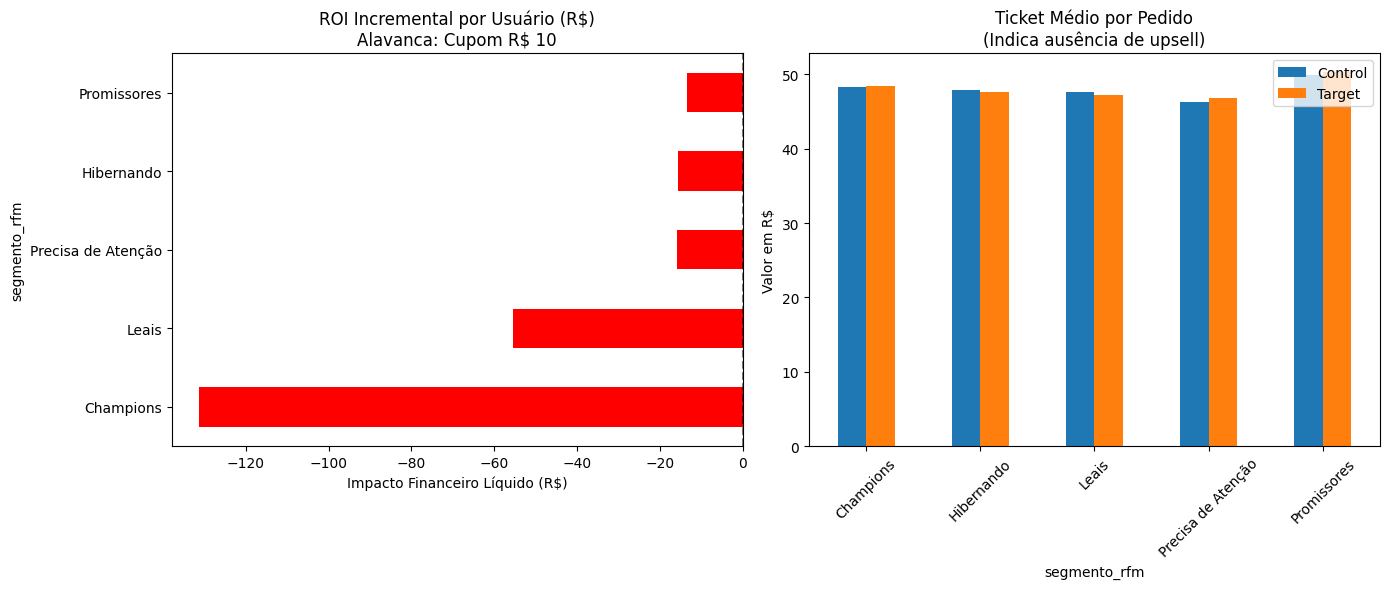

In [29]:
# --- 4. VISUALIZAÇÃO DOS RESULTADOS ---
plt.figure(figsize=(14, 6))

# Gráfico 1: ROI por Usuário
plt.subplot(1, 2, 1)
colors = ['red' if x < 0 else 'green' for x in pdf_pivot['ROI_por_Usuario (R$)'].sort_values()]
pdf_pivot['ROI_por_Usuario (R$)'].sort_values().plot(kind='barh', color=colors)
plt.title('ROI Incremental por Usuário (R$)\nAlavanca: Cupom R$ 10')
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
plt.xlabel('Impacto Financeiro Líquido (R$)')

# Gráfico 2: Ticket Médio Comparativo
# Mostra que o cupom não está "puxando" o ticket para cima
pdf_ticket = pd.DataFrame({
    'Control': pdf_pivot['total_gmv_control'] / pdf_pivot['total_orders_control'],
    'Target': pdf_pivot['total_gmv_target'] / pdf_pivot['total_orders_target']
})
plt.subplot(1, 2, 2)
pdf_ticket.plot(kind='bar', ax=plt.gca())
plt.title('Ticket Médio por Pedido\n(Indica ausência de upsell)')
plt.ylabel('Valor em R$')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

--- COMPARAÇÃO DE ROI POR USUÁRIO (CENÁRIO A vs B) ---


,roi_per_user_A,roi_per_user_B
segmento_rfm,,
Champions,-131.332132,-9.681966
Precisa de Atenção,-15.826148,-9.711658
Promissores,-13.509374,-9.889927
Hibernando,-15.576719,-9.945519
Leais,-55.425045,-10.086568


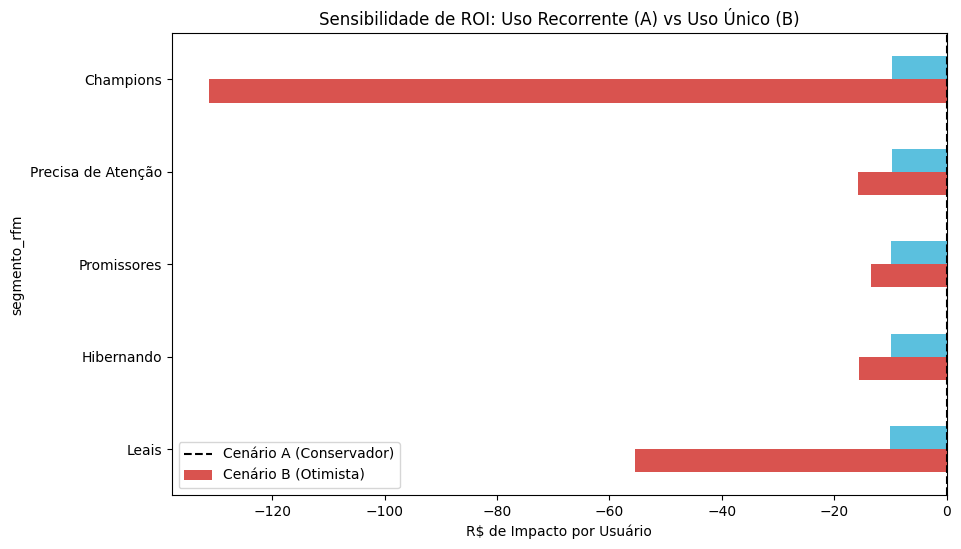

In [30]:
# --- 1. CÁLCULO DOS CENÁRIOS ---

# Cenário A (Conservador): Custo = Total de Pedidos * R$ 10 (Premissa atual)
pdf_pivot['custo_total_A'] = pdf_pivot['total_orders_target'] * CUSTO_CUPOM
pdf_pivot['lucro_A'] = (pdf_pivot['total_gmv_target'] * TAKE_RATE) - pdf_pivot['custo_total_A'] - pdf_pivot['receita_esperada_target']
pdf_pivot['roi_per_user_A'] = pdf_pivot['lucro_A'] / pdf_pivot['n_users_target']

# Cenário B (Otimista): Custo = Total de Usuários * R$ 10 (Apenas 1 cupom por pessoa)
pdf_pivot['custo_total_B'] = pdf_pivot['n_users_target'] * CUSTO_CUPOM
pdf_pivot['lucro_B'] = (pdf_pivot['total_gmv_target'] * TAKE_RATE) - pdf_pivot['custo_total_B'] - pdf_pivot['receita_esperada_target']
pdf_pivot['roi_per_user_B'] = pdf_pivot['lucro_B'] / pdf_pivot['n_users_target']

# --- 2. EXIBIÇÃO E COMPARAÇÃO ---
print("--- COMPARAÇÃO DE ROI POR USUÁRIO (CENÁRIO A vs B) ---")
display(pdf_pivot[['roi_per_user_A', 'roi_per_user_B']].sort_values(by='roi_per_user_B', ascending=False))

# --- 3. VISUALIZAÇÃO ---
df_plot = pdf_pivot[['roi_per_user_A', 'roi_per_user_B']].sort_values(by='roi_per_user_B')
df_plot.plot(kind='barh', figsize=(10, 6), color=['#d9534f', '#5bc0de'])
plt.title('Sensibilidade de ROI: Uso Recorrente (A) vs Uso Único (B)')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('R$ de Impacto por Usuário')
plt.legend(['Cenário A (Conservador)', 'Cenário B (Otimista)'])
plt.show()

In [31]:
# Premissas Adotadas
TAKE_RATE = 0.15   # Comissão do iFood
CUSTO_CUPOM = 10.0 # Premissa conservadora por pedido no grupo Target

# Master Table para Análise
df_analytics = df_segmentation_final.join(df_ab, "customer_id", "inner")

def run_roi_analysis(dimension):
    # Agregação por Dimensão
    res = df_analytics.groupBy(dimension, "is_target").agg(
        F.count("customer_id").alias("n_users"),
        F.sum("frequency").alias("total_orders"),
        F.sum("monetary").alias("total_gmv")
    ).toPandas()

    # Pivotagem para Cálculo de Incrementalidade
    pdf = res.pivot(index=dimension, columns='is_target').fillna(0)
    pdf.columns = [f"{col}_{group}" for col, group in pdf.columns]

    # Baseline: O que o controle rende por usuário (ARPU Líquido)
    pdf['arpu_c'] = (pdf['total_gmv_control'] * TAKE_RATE) / pdf['n_users_control']

    # ROI Incremental por Usuário (Receita Real Target - Baseline Esperada)
    pdf['roi_per_user'] = ((pdf['total_gmv_target'] * TAKE_RATE) -
                           (pdf['total_orders_target'] * CUSTO_CUPOM) -
                           (pdf['n_users_target'] * pdf['arpu_c'])) / pdf['n_users_target']

    return pdf[['roi_per_user']].sort_values(by='roi_per_user', ascending=False)

# Exibição dos Resultados
print("ROI por Segmento RFM:")
display(run_roi_analysis("segmento_rfm"))

print("\nROI por Perfil de Bolso:")
display(run_roi_analysis("perfil_bolso"))

ROI por Segmento RFM:


,roi_per_user
segmento_rfm,
Promissores,-13.509374
Hibernando,-15.576719
Precisa de Atenção,-15.826148
Leais,-55.425045
Champions,-131.332132



ROI por Perfil de Bolso:


,roi_per_user
perfil_bolso,
Econômico,-40.635455
Premium,-41.431242
Moderado,-47.167094


# Glossário (termos e indicadores)

Este glossário resume os principais termos e métricas usados ao longo do notebook.

### Grupos do experimento
- **Control (controle)**: usuários que **não** receberam a oferta de cupom (baseline).
- **Target (tratamento)**: usuários que **receberam** a oferta de cupom.

### Unidades e conceitos
- **Unidade de análise (user-level)**: as métricas do A/B são calculadas **por usuário** (ex.: GMV por usuário, pedidos por usuário), para evitar que usuários muito ativos dominem a análise por terem mais pedidos.
- **Janela observada**: período coberto pelos dados (confirmado via min/max de `order_created_at`).  
  Importante para retenção porque há **censura à direita** no final da janela.

### Indicadores de retenção (métrica primária)
- **Primeiro pedido (`first_order_ts`)**: timestamp do **primeiro pedido observado** do usuário na janela.
- **Segundo pedido (`second_order_ts`)**: timestamp do **primeiro pedido após o primeiro** (primeira recompra) na janela.
- **Dias até recompra (`days_to_2nd`)**: diferença em dias entre `second_order_ts` e `first_order_ts`.  
  Interpretação: quanto menor, mais rápido o usuário recompra.

- **Retenção D7 / D14 / D30 (`retained_d7`, `retained_d14`, `retained_d30`)**: indicador binário (0/1):
  - `1` se o usuário fez a **primeira recompra** em até **7/14/30 dias** após o primeiro pedido;
  - `0` caso contrário.
  > Observação: este notebook mede “retorno em até X dias” usando o **2º pedido** como evento de recompra.

- **Elegibilidade D7/D14/D30 (`eligible_d7`, `eligible_d14`, `eligible_d30`)**: indicador binário (0/1) para tratar **censura**:
  - `1` se o `first_order_ts` ocorre **até** `(data_máxima − X dias)`;
  - `0` caso contrário.
  Isso garante que todos os usuários incluídos em D7/D14/D30 tiveram “tempo suficiente” para recomprar dentro do horizonte.

- **Taxa de retenção Dk (`retention_rate`)**:  
  \[
  \text{Retenção Dk} = \frac{\#\text{usuários retidos em Dk}}{\#\text{usuários elegíveis em Dk}}
  \]

- **IC 95% (Wilson)**: intervalo de confiança de 95% para proporções (retenção), mais estável que aproximações simples quando a taxa é muito baixa ou muito alta.
- **Teste de diferença de proporções (z-test)**: testa se a retenção do grupo target difere da retenção do grupo control (p-value).

### Indicadores de valor e frequência (métricas secundárias)
- **GMV (Gross Merchandise Value)**: valor bruto transacionado (soma do valor dos pedidos).
- **GMV por usuário (`gmv_user`)**: soma do valor dos pedidos do usuário na janela.
- **Pedidos por usuário (`orders_user`)**: número de pedidos do usuário na janela.
- **AOV / Ticket médio (Average Order Value)**:  
  \[
  \text{AOV} = \frac{\text{GMV}}{\#\text{pedidos}}
  \]
  Pode ser calculado globalmente, por grupo, ou por usuário (dependendo do contexto).

- **Série temporal normalizada (pedidos por usuário/dia)**: número de pedidos por dia dividido pela base de usuários do grupo.  
  Ajuda a comparar tendências sem viés de “tamanho de grupo”.

### Segmentação (RFM)
- **RFM**: conjunto de features para segmentar usuários por comportamento:
  - **R (Recency)**: quão recente foi a última compra (quanto menor, mais recente).
  - **F (Frequency)**: quantas compras o usuário fez (quanto maior, mais frequente).
  - **M (Monetary)**: quanto o usuário gastou (quanto maior, maior valor).
- **Cluster/segmento RFM**: agrupamento de usuários com perfis semelhantes em R/F/M.  
  Usado para analisar **heterogeneidade de impacto** (efeito do cupom varia por segmento).

### Indicadores de impacto e viabilidade
- **Lift (incremento)**: diferença entre grupos (target − control) em uma métrica.
  - Ex.: `lift_retencao_pp = (ret_target − ret_control) * 100` (em pontos percentuais)
  - Ex.: `lift_gmv_user = avg_gmv_user_target − avg_gmv_user_control`

- **GMV incremental total (aproximação)**:
  \[
  \Delta \text{GMV total} \approx (\overline{\text{GMV/user}}_{target} - \overline{\text{GMV/user}}_{control}) \times N_{target}
  \]

- **Take rate (aprox.)**: percentual do GMV que se converte em receita/margem para a plataforma (premissa para cenários).
- **Custo do cupom (cenário)**: custo médio por pedido com cupom (premissa) multiplicado por:
  - número de pedidos do target,
  - e **taxa de resgate** (percentual de pedidos no target que realmente usaram cupom).

- **Impacto líquido (net impact)**:
  \[
  \text{Net} = (\text{take rate} \times \Delta \text{GMV total}) - \text{custo total do cupom}
  \]

- **ROI (retorno sobre investimento)**:
  \[
  \text{ROI} = \frac{\text{Net}}{\text{custo total do cupom}}
  \]

### Observações importantes (limitações)
- **Cauda pesada (heavy tail)**: métricas de gasto (GMV/AOV) costumam ter poucos usuários com valores muito altos.  
  Por isso, além de médias, é útil olhar dispersão e (idealmente) intervalos de confiança/bootstrapping.
- **Instrumentação de desconto**: se o dataset não traz o valor efetivo do desconto aplicado, a análise financeira depende de **cenários** (premissas) para custo e taxa de resgate.
